Epoch 1/80
531/531 [==============================] - 2s 3ms/step - loss: 1.2843e-06
Epoch 2/80
531/531 [==============================] - 1s 3ms/step - loss: 4.2927e-07
Epoch 3/80
531/531 [==============================] - 1s 3ms/step - loss: 2.5042e-06
Epoch 4/80
531/531 [==============================] - 1s 3ms/step - loss: 2.5783e-07
Epoch 5/80
531/531 [==============================] - 1s 3ms/step - loss: 9.7320e-08
Epoch 6/80
531/531 [==============================] - 1s 3ms/step - loss: 8.3244e-08
Epoch 7/80
531/531 [==============================] - 1s 3ms/step - loss: 7.7123e-08
Epoch 8/80
531/531 [==============================] - 1s 3ms/step - loss: 7.7490e-08
Epoch 9/80
531/531 [==============================] - 1s 3ms/step - loss: 7.1441e-08
Epoch 10/80
531/531 [==============================] - 1s 3ms/step - loss: 7.0887e-08
Epoch 11/80
531/531 [==============================] - 1s 3ms/step - loss: 7.0249e-08
Epoch 12/80
531/531 [==============================] - 1s 3ms/s

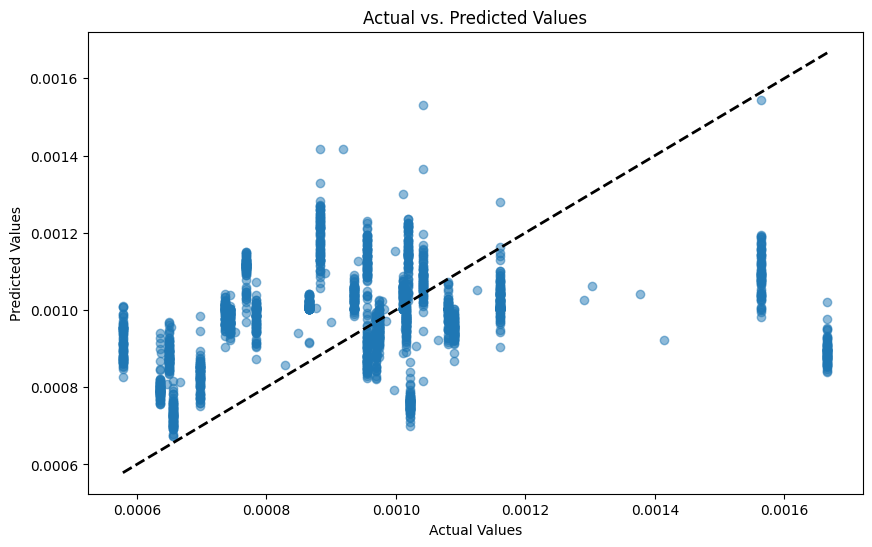

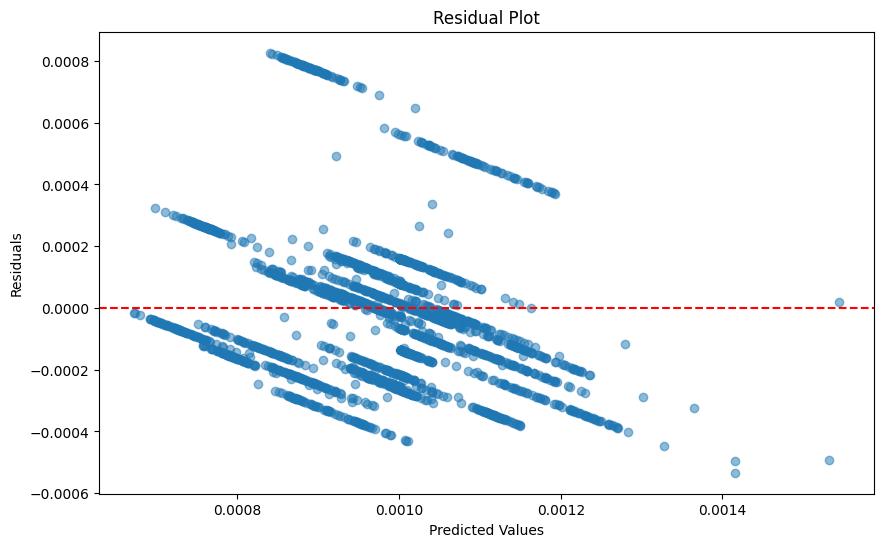

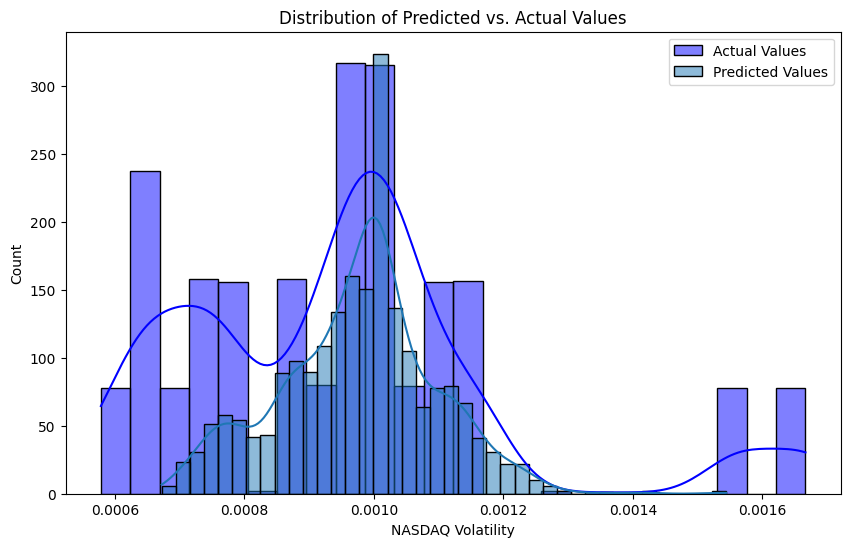

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

import os
import random

def custom_set_seed(seed_value):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    
custom_set_seed(42)

df = pd.read_csv('combined_dataset.csv')


df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
df.set_index(df.columns[0], inplace=True)

numeric_df = df.select_dtypes(include=[np.number])


correlation_matrix = numeric_df.corr()

# Extract correlations with 'nasdaq_volatility' and filter based on absolute value
nasdaq_volatility_correlations = correlation_matrix['NASDAQ_Volatility']
significant_correlations = nasdaq_volatility_correlations[abs(nasdaq_volatility_correlations) > 0.05]

# Filter the columns in df based on significant correlations
filtered_columns = significant_correlations.index.tolist()
filtered_df = df[filtered_columns]

# Define the split date
split_date = pd.Timestamp('2023-10-01')

# Split the data into train and test sets
train = filtered_df.loc[df.index < split_date]
test = filtered_df.loc[df.index >= split_date]

X_train, y_train = train.drop(columns=['NASDAQ_Volatility']).values, train['NASDAQ_Volatility'].values
X_test, y_test = test.drop(columns=['NASDAQ_Volatility']).values, test['NASDAQ_Volatility'].values

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LSTM layer
n_timesteps = 1 
X_train = X_train.reshape((X_train.shape[0], n_timesteps, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], n_timesteps, X_test.shape[1]))

# Build the model
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=(n_timesteps, X_train.shape[2])))
model.add(LSTM(70, activation='relu', return_sequences=False))
model.add(Dropout(0.20))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))



# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=80, batch_size=32, verbose=1)

# Predict using the test set
y_pred = model.predict(X_test)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
#print("R-squared:", r_squared)
print("Mean Squared Error:", mse)
# Assuming 'df' is your DataFrame and 'NASDAQ_Volatility' is your target variable
min_value = df['NASDAQ_Volatility'].min()
max_value = df['NASDAQ_Volatility'].max()

print("Minimum value of NASDAQ_Volatility:", min_value)
print("Maximum value of NASDAQ_Volatility:", max_value)

import matplotlib.pyplot as plt
import seaborn as sns

# Actual vs. Predicted Values Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# Residual Plot
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Distribution of Predicted vs. Actual Values
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color="blue", label="Actual Values", kde=True)
sns.histplot(y_pred, color="red", label="Predicted Values", kde=True)
plt.title('Distribution of Predicted vs. Actual Values')
plt.xlabel('NASDAQ Volatility')
plt.legend()
plt.show()
